# Deep Learning : 3D shapes




## Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=500,precision=2,suppress=True)
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error


from IPython.display import clear_output

2023-01-24 09:19:15.591231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Utils

In [2]:
def progression(i, n):
    i += 1
    k = int(i/n*20)
    print(f'\rProgression:[{k*"#"}{(20-k)*" "}] [{(i/n*100):.0f} %]',
          end='' if i != n else "\n", flush=True)

In [3]:
def plot_loss_acc(history):

    fig, axs = plt.subplots(1,2,figsize=(15,4))
    axs[0].set_title("Loss")
    axs[0].plot(history.history['loss'], label='loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[0].set_xlabel('Epoch #')
    axs[0].legend()

    axs[1].set_title("Accuracy")
    axs[1].plot(history.history['accuracy'], label='accuracy')
    axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
    axs[1].set_xlabel('Epoch #')
    axs[1].legend();

In [4]:
def plot_test_pred(Y_test, Y_pred, titles) :

    n = Y_pred.shape[-1]

    

    if n<=2 :
      if n == 2 :
        fig, axs = plt.subplots(1,2, figsize=(7*n,4))
        for i in range(n) :
            axs[i].set_title(titles[i])
            axs[i].scatter(Y_test[:,i], Y_pred[:,i], alpha=0.1)
            abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
            axs[i].plot(abscisse, abscisse, 'k')
            axs[i].set_xlabel('Test')
            axs[i].set_ylabel('Pred')
      if n== 1 :
          fig, axs = plt.subplots(1,1, figsize=(10,4))
          axs.set_title(titles[0])
          axs.scatter(Y_test[:,0], Y_pred[:,0], alpha=0.1)
          abscisse=np.linspace(0,np.max(Y_test[:,0]),1000)
          axs.plot(abscisse, abscisse, 'k')
          axs.set_xlabel('Test')
          axs.set_ylabel('Pred')

    else :
      fig, axs = plt.subplots( (n+1)//2,2, figsize=(14, 3*n))
      for i in range(n) :
          axs[i//2, i%2].set_title(titles[i])
          axs[i//2, i%2].scatter(Y_test[:,i], Y_pred[:,i], alpha=0.1)
          abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
          axs[i//2, i%2].plot(abscisse, abscisse, 'k')
          axs[i//2, i%2].set_xlabel('Test')
          axs[i//2, i%2].set_ylabel('Pred')
    plt.tight_layout();

In [5]:
def plot_test_pred_corr(Y_test, Y_pred, titles, Corr, corr_label) :

    n = Y_pred.shape[-1]

    if n<=2 :
        if n == 2 :
            fig, axs = plt.subplots(1,2, figsize=(7*n,4))
            for i in range(n) :
                axs[i].set_title(titles[i])
                im = axs[i].scatter(Y_test[:,i],Y_pred[:,i],c=Corr,edgecolors=None,alpha=0.7,marker='o',cmap='jet')
                abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
                axs[i].plot(abscisse, abscisse, 'k')
                axs[i].set_xlabel('Test')
                xs[i].set_ylabel('Pred')
                divider = make_axes_locatable(axs)
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(im, cax=cax, orientation='vertical', label=corr_label)
                
        if n== 1 :
            fig, axs = plt.subplots(1,1, figsize=(10,4))
            axs.set_title(titles[0])
            im = axs.scatter(Y_test[:,0],Y_pred[:,0],c=Corr,edgecolors=None,alpha=0.7,marker='o',cmap='jet')
            abscisse=np.linspace(0,np.max(Y_test[:,0]),1000)
            axs.plot(abscisse, abscisse, 'k')
            axs.set_xlabel('Test')
            axs.set_ylabel('Pred')
            divider = make_axes_locatable(axs)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical', label=corr_label)
    else :
        fig, axs = plt.subplots( (n+1)//2,2, figsize=(14, 3*n))
        for i in range(n) :
            xs[i//2, i%2].set_title(titles[i])
            im = axs[i//2, i%2].scatter(Y_test[:,i],Y_pred[:,i],c=Corr,edgecolors=None,alpha=0.7,marker='o',cmap='jet')
            abscisse=np.linspace(0,np.max(Y_test[:,i]),1000)
            axs[i//2, i%2].plot(abscisse, abscisse, 'k')
            axs[i//2, i%2].set_xlabel('Test')
            axs[i//2, i%2].set_ylabel('Pred')
            divider = make_axes_locatable(axs[i//2, i%2])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(im, cax=cax, orientation='vertical', label=corr_label)
    plt.tight_layout();

## Data

### Import

In [2]:
catalog='../Data/ImageCat.txt'
filename=np.genfromtxt(catalog,skip_header=1,dtype='U60',usecols=0)
data=np.genfromtxt(catalog,skip_header =1, usecols=[1,2,3,4,5,6,7])  #filename	log(M/M_sun)	r_2/kpc	n	q=b/a	p=c/b	phi/pi	theta/pi

In [7]:
data.shape, data[0,:]

((10120, 7), array([10.  ,  0.1 ,  1.01,  0.19,  0.38,  0.46,  0.29]))

### Treatment

In [3]:
R    = np.copy(data[:,1])
n    = np.copy(data[:,2])

In [4]:
def sigma_calc(n, R):
    rho0 = 1

    sigma = np.zeros((100, 100))

    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    z = np.linspace(-1, 1, 100)

    X_, Y_ = np.meshgrid(x, y) 

    for j in range(100) :
        sigma[:][:] = sigma[:][:] + rho0 * np.exp( -2*n * (np.sqrt(X_**2 + Y_**2 + z[j]**2)/R)**(1/n) )
        
    return sigma

### Plot one galaxy

### Spherical

In [5]:
sigma = sigma_calc(n,R)
sigma = sigma.astype('float32') 
sigma = sigma[:,:,:,None]
sigma.shape

In [8]:
Y = np.stack([R, n],axis=1)
Y= Y.astype('float32')
Y.shape, Y.dtype

size = Y.shape[0] 
Y = Y[:size]

D=np.copy(sigma)

#Uncomment if log scale is wanted
#D=np.zeros((sigma.shape[0],sigma.shape[1], sigma.shape[2],1)) 
#for i in range(size):
#    D[i]=np.log10(sigma[i])

D = D.astype('float32') 

ngal=np.shape(D)[0]
print("The catalog comprises %i galaxies"%ngal)

The catalog comprises 10120 galaxies


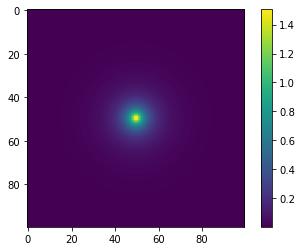

In [10]:
plt.imshow(D[1000])
plt.colorbar()

## Models

### Model 1 : Convolution

In [13]:
class Model1(tf.keras.Model):

    def __init__(self, dimout):
        super().__init__()
        self.layer1=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')
        #self.dropout1=tf.keras.layers.Dropout(0.25)
        self.layer2=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer3=tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')
        self.layer4=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer5=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')

        self.flatten=tf.keras.layers.Flatten()
        self.dense1=tf.keras.layers.Dense(1024,activation='relu')
        self.dense2=tf.keras.layers.Dense(512,activation='relu')
        self.dense3=tf.keras.layers.Dense(dimout)
        print(f"Dim out = {dimout}")

        self.max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))


    @tf.function
    def call(self,X,training=True):

        out=self.layer1(X)
        #out=self.dropout1(out, training)
        out=self.max_pool(out)
        out=self.layer2(out)
        out=self.max_pool(out)
        out=self.layer3(out)
        out=self.max_pool(out)
        out=self.layer4(out)
        out=self.max_pool(out)
        out=self.layer5(out)
        out=self.max_pool(out)

        out=self.flatten(out)

        out=self.dense1(out)
        out=self.dense2(out)
        
        return self.dense3(out)



## Tests

[0.9  1.19]


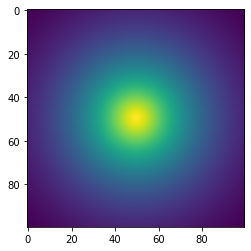

In [16]:
#Relancer plusieurs fois la cellule pour voir que l'on permute aléatoirement les données
shuffle= np.arange(D.shape[0])
np.random.shuffle(shuffle)

Y = Y[shuffle]
D = D[shuffle]
sigma = sigma[shuffle]

print(Y[100])
plt.imshow(D[100,:,:,0]);

In [17]:
res_data = pd.DataFrame()

l = len(D)
train_size = int(0.7 * l)
val_size = int(0.15 * l)

X_train = D[:train_size]
Y_train = Y[:train_size]

X_val = D[train_size:train_size+val_size]
Y_val = Y[train_size:train_size+val_size]

X_test = D[train_size+val_size:]
Y_test = Y[train_size+val_size:]

### Parameter n

#### With normalization

In [19]:
Y_train_n = Y_train[:,1]
Y_train_n = Y_train_n[:, None]

Y_val_n = Y_val[:, 1]
Y_val_n = Y_val_n[:, None]

Y_test_n = Y_test[:, 1]
Y_test_n = Y_test_n[:, None]

Y_train_n.shape, Y_val_n.shape, Y_test_n.shape

((7084, 1), (1518, 1), (1518, 1))

##### Spherical

In [50]:
model1_spherical = Model1(1)

model1_spherical.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

Dim out = 1


2023-01-23 17:55:56.775710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [86]:
checkpoint_filepath = './spherical_checkpoints/my_checkpoint_nolog'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
batch_size = 64
nb_epoch = 30

history = model1_spherical.fit(X_train, Y_train_n,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_val, Y_val_n),
    callbacks=[model_checkpoint_callback])


model1_spherical.load_weights(checkpoint_filepath)

model1_spherical.save_weights(checkpoint_filepath)

In [21]:

# Create a new model instance
model1_spherical = Model1(1)

# Restore the weights
model1_spherical.load_weights('./spherical_checkpoints/my_checkpoint_nolog')
model1_spherical.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

# Evaluate the model
loss, acc = model1_spherical.evaluate(X_train, Y_train_n, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

2023-01-24 09:21:45.955532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dim out = 1
222/222 - 10s - loss: 0.1116 - accuracy: 0.0024 - 10s/epoch - 47ms/step
Restored model, accuracy:  0.24%


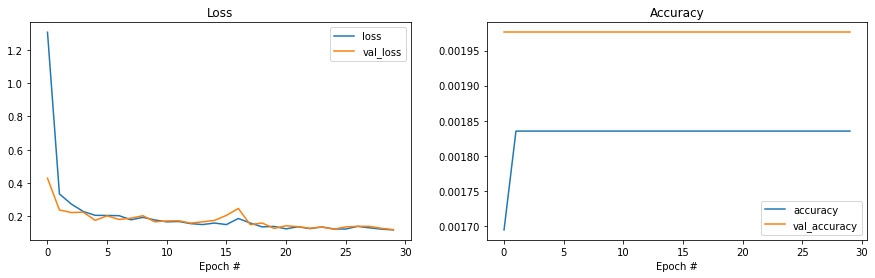

In [88]:
plot_loss_acc(history)
#plt.savefig('images/history_spherical_nolog.png', dpi=100)

In [22]:
Y_pred_n_spherical = model1_spherical(X_test)
Y_pred_n_spherical.shape

TensorShape([1518, 1])

In [23]:
# TRACE THE RADIAL DENSITY PROFILE
def radial_profile(data, center):
    y,x = np.indices((data.shape)) # first determine radii of all pixels
    r = np.sqrt((x-center[0])**2+(y-center[1])**2)
    ind = np.argsort(r.flat) # get sorted indices
    sr = r.flat[ind] # sorted radii
    sim = data.flat[ind] # image values sorted by radii    
    ri = sr.astype(np.int32) # integer part of radii (bin size = 1)
    # determining distance between changes
    deltar = ri[1:] - ri[:-1] # assume all radii represented
    rind = np.where(deltar)[0] # location of changed radius
    nr = rind[1:] - rind[:-1] # number in radius bin
    csim = np.cumsum(sim, dtype=np.float64) # cumulative sum to figure out sums for each radii bin
    tbin = csim[rind[1:]] - csim[rind[:-1]] # sum for image values in radius bins
    radialprofile = tbin/nr # the answer
    return radialprofile

def deprojected_profile(data,center,PA_rad,AR):
    y,x = np.indices((data.shape)) # first determine position of all pixels
    x=x-center[0] # take center as origin
    y=y-center[1]
    xp=x*cos(PA_rad)+y*sin(PA_rad) # rotate by the position angle PA
    yp=-x*sin(PA_rad)+y*cos(PA_rad)
    rp=np.sqrt((xp/AR)**2+yp**2) # determine the deprojected radius
    ind = np.argsort(rp.flat) # get sorted indices
    sr = rp.flat[ind] # sorted radii
    sim = data.flat[ind] # image values sorted by radii    
    rpi = sr.astype(np.int32) # integer part of radii (bin size = 1)
    # determining distance between changes
    deltarp = rpi[1:] - rpi[:-1] # assume all radii represented
    rpind = np.where(deltarp)[0] # location of changed radius
    nrp = rpind[1:] - rpind[:-1] # number in radius bin
    csim = np.cumsum(sim, dtype=np.float64) # cumulative sum to figure out sums for each radii bin
    tbin = csim[rpind[1:]] - csim[rpind[:-1]] # sum for image values in radius bins
    radialprofile = tbin/nrp # the answer
    return radialprofile  

def center_coord(model,center):
    import re
    limits=re.findall("\d+\d+",model.header['FITSECT'])
    xc=int(limits[0])+center[0]
    yc=int(limits[2])+center[1]
    return xc, yc

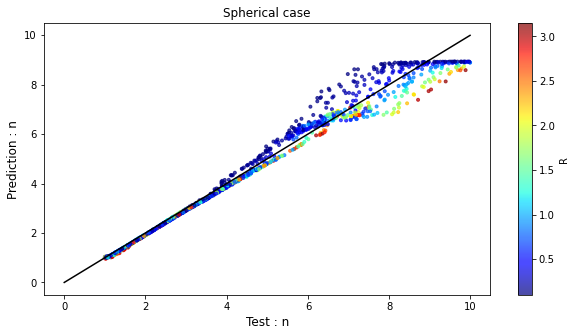

In [33]:
fig, ax =  plt.subplots(1,1, figsize = (10,5))

abscisse=np.linspace(0,np.max(Y_test_n[:,0]),1000)

im = ax.scatter(Y_test_n[:,0],Y_pred_n_spherical[:,0],c=Y_test[:,0],edgecolors=None,alpha=0.7,marker='.',cmap='jet')
ax.plot(abscisse, abscisse, 'k')
ax.set_xlabel('Test : n', size=12)
ax.set_ylabel('Prediction : n', size=12)
ax.set_title('Spherical case')
fig.colorbar(im, ax=ax, orientation='vertical', label='R')

#plt.savefig('pred_spher.png', dpi=100)

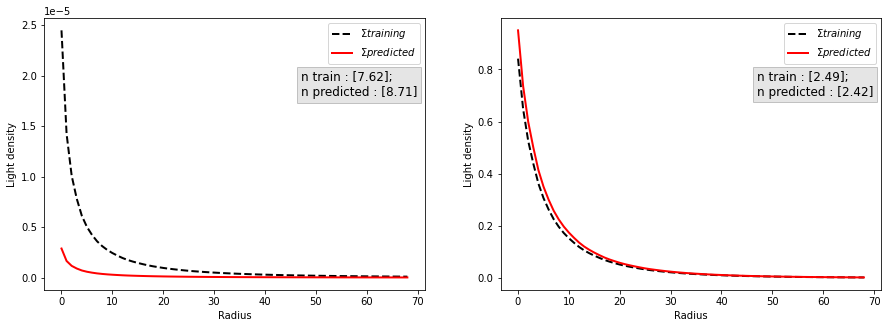

In [50]:
fig, ax =  plt.subplots(1,2, figsize = (15,5))

i=38

sigma_train = sigma_calc(Y_test_n[i], Y_test[i, 0])
sigma_pred = sigma_calc(Y_pred_n_spherical[i], Y_test[i, 0])

center = [50,50]
radial_image_train=radial_profile(sigma_train,center)
radial_image_pred=radial_profile(sigma_pred,center)
radius=range(len(radial_image_train))

ax[0].plot(np.array(radius),radial_image_train,color='black', linestyle='--',linewidth=2,label=r'$\Sigma training$')
ax[0].plot(np.array(radius),radial_image_pred,color='red',linewidth=2,label=r'$\Sigma predicted$')
ax[0].set_xlabel('Radius')
ax[0].set_ylabel('Light density')
ax[0].legend()


ax[0].text(47, 1.8e-5, 'n train : %s; \nn predicted : %s'%(Y_test_n[i], np.array(Y_pred_n_spherical[i])), fontsize=12,
          bbox=dict(facecolor='grey', alpha=0.2))


i=42

sigma_train = sigma_calc(Y_test_n[i], Y_test[i, 0])
sigma_pred = sigma_calc(Y_pred_n_spherical[i], Y_test[i, 0])

radial_image_train=radial_profile(sigma_train,center)
radial_image_pred=radial_profile(sigma_pred,center)
radius=range(len(radial_image_train))

ax[1].plot(np.array(radius),radial_image_train,color='black', linestyle='--',linewidth=2,label=r'$\Sigma training$')
ax[1].plot(np.array(radius),radial_image_pred,color='red',linewidth=2,label=r'$\Sigma predicted$')
ax[1].set_xlabel('Radius')
ax[1].set_ylabel('Light density')
ax[1].legend()

ax[1].text(47, 0.7, 'n train : %s; \nn predicted : %s'%(Y_test_n[i], np.array(Y_pred_n_spherical[i])), fontsize=12,
          bbox=dict(facecolor='grey', alpha=0.2))

#plt.savefig('images/comp_profils.png', dpi=100)

### Parameter R

#### Initial

In [43]:
Y_train_R = Y_train[:,0]
Y_train_R = Y_train_R[:, None]

Y_val_R = Y_val[:, 0]
Y_val_R = Y_val_R[:, None]

Y_test_R = Y_test[:, 0]
Y_test_R = Y_test_R[:, None]

Y_train_R.shape, Y_val_R.shape, Y_test_R.shape

((7084, 1), (1518, 1), (1518, 1))

In [44]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_R = Model1(1)

model_R.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

Dim out = 1


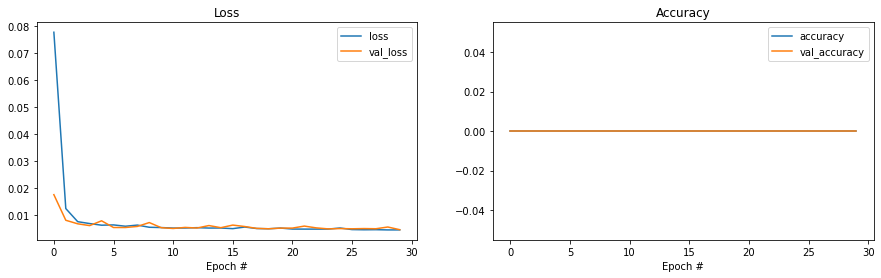

In [47]:
plot_loss_acc(history)
#plt.savefig('images/history_R.png', dpi=100)

In [48]:
# Save the weights
model_R.save_weights('./checkpoints/my_checkpoint_R')

In [49]:
Y_pred_R = model_R(X_test)
Y_pred_R.shape

TensorShape([1518, 1])

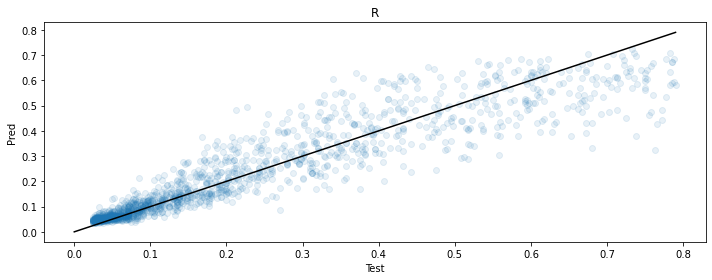

In [50]:
plot_test_pred(Y_test_R, Y_pred_R, ["R"])

In [ ]:
fig, axs = plt.subplots(5,1, figsize=(10,20))

axs[0].set_title("R corr with n")
axs[0].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,1],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[0].plot(abscisse, abscisse, 'k')
axs[0].set_xlabel('Test')
axs[0].set_ylabel('Pred')

axs[1].set_title("R corr with q")
axs[1].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,2],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[1].plot(abscisse, abscisse, 'k')
axs[1].set_xlabel('Test')
axs[1].set_ylabel('Pred')

axs[2].set_title("R corr with p")
axs[2].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,3],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[2].plot(abscisse, abscisse, 'k')
axs[2].set_xlabel('Test')
axs[2].set_ylabel('Pred')

axs[3].set_title(r"R corr with $\phi$")
axs[3].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,4],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[3].plot(abscisse, abscisse, 'k')
axs[3].set_xlabel('Test')
axs[3].set_ylabel('Pred')

axs[4].set_title(r"R corr with $\theta$")
axs[4].scatter(Y_test_R[:,0],Y_pred_R[:,0],c=Y_test[:,5],edgecolors=None,alpha=0.7,marker='o',cmap='jet')
abscisse=np.linspace(0,np.max(Y_test_R[:,0]),1000)
axs[4].plot(abscisse, abscisse, 'k')
axs[4].set_xlabel('Test')
axs[4].set_ylabel('Pred')


plt.tight_layout()

In [ ]:
plot_test_pred_corr(Y_test_R,Y_pred_R, ["R corr with R"], Y_test[:,0])

#### Spherical

In [ ]:
modelR_spherical = Model1(1)

modelR_spherical.compile(
    optimizer=tf.optimizers.Adam(1e-4),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

In [ ]:
batch_size = 64
nb_epoch = 70

history = modelR_spherical.fit(X_spher_train, Y_train_R,
    batch_size = batch_size, 
    epochs=nb_epoch,
    validation_data=(X_spher_val, Y_val_R),
    callbacks=[model_checkpoint_callback])


modelR_spherical.load_weights(checkpoint_filepath)

In [ ]:
plot_loss_acc(history)

In [ ]:
Y_pred_R_spherical = modelR_spherical(X_spher_test)
Y_pred_R_spherical.shape

In [ ]:
plot_test_pred(Y_test_R, Y_pred_R_spherical, ["R"])

In [ ]:
plot_test_pred_corr(Y_test_R,Y_pred_R_spherical, ["R corr with n"], Y_test[:,1])